In [198]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import pandas as pd
from datetime import datetime
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from scipy.stats import multivariate_normal
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
import seaborn as sns
from datetime import date
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 100})

# 1. Bayesian Theorem

## 1.1 Task

$$
P(I|E) = P(E|I)\frac{P(I)}{P(E)}, where
$$

$ P(I) - \mbox{prior probablity that man is innocent not depending on the test result} $ \
$ P(E) - \mbox{prior probablity that test is observed} $ \
$ P(E|I) - \mbox{probability that test is observed given that man is innocent} $ \
$ P(I|E) - \mbox{probability that man is innocent given despite the test is observed} $

$ \mbox{We see that } P(E|I) \mbox{ is small - that prosecutor evaluated. Prosecutor mistakes when tells that }  P(I|E) \mbox{ is small - that prosecutor should evaluate.} $ \
$ \mbox{In fact } P(E|I) \mbox{ and} P(I|E) \mbox{ are different from each other.} $ \
$ \mbox{Equation above shows that small } P(E|I) \mbox{ does not imply small } P(I|E) \mbox{ in case of big value of } P(I) \mbox{ and small value } P(E). $ 
$ \mbox{I.E if in other case man can be innocent and hardly somebody presents observed evidence.} $

## 1.2 Task

$$
P(G|E) = P(E|G)\frac{P(G)}{P(E)}, where
$$

$ P(G) - \mbox{prior probablity that man is guilty not depending on the test result} $ \
$ P(E) - \mbox{prior probablity that test is observed} $ \
$ P(E|G) - \mbox{probability that test is observed given that man is guilty} $ \
$ P(G|E) - \mbox{probability that man is guilty given despite the test is observed} $

$ \mbox{The defender tries to evaluate P(G|E)} $ \
$ \mbox{but he estimates prior guilty probability as 1/1000000. In defender's calculation prior guilty} $ 
$ \mbox{probability is not evaluated properly because not all of people in the city are suspects} $ 

## 1.3 Task

In [199]:
def aposterior_positive_prob(false_positive):
    return ((1 - false_positive) * 0.01) / ((1 - false_positive) * 0.01 + false_positive * 0.99)
def aposterior_negative_prob(false_negative):
    return (false_negative * 0.01) / (false_negative * 0.01 + (1 - false_negative) * 0.99)

In [200]:
x = np.arange(0, 0.05, 0.0001)

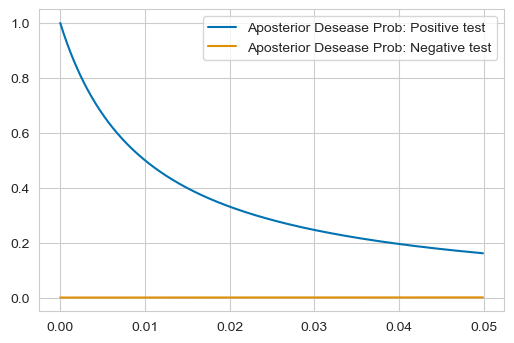

In [201]:
plt.plot(x, aposterior_positive_prob(x))
plt.plot(x, aposterior_negative_prob(x))
plt.legend(["Aposterior Desease Prob: Positive test", "Aposterior Desease Prob: Negative test"])

$ \mbox{We can see that aposterior_positive_prob changes significantly with the growth of false_positive value} $ \
$ \mbox{and vice versa  aposterior_negative_prob changes not much, so conclusion to concentrate on reducing false_positives} $

# 2. Linear Regression

### 2.1 Train Linear Model y ~ exp(linear function(x))

### Total Cases ( to obtain results on new cases just change target)

In [202]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
df = pd.read_csv(url)

In [203]:
target = 'total_cases' 
#target = 'new_cases'

In [204]:
date_format = "%Y-%m-%d"
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= '2020-03-03']
df.loc[df["new_cases"] == 0, "new_cases"] = 1
df = df.reset_index(drop=True)
df['current_date'] = (df['date'] - df['date'].min()).dt.days + 1

In [205]:
russia = df[(df['location'] == 'Russia')].reset_index(drop=True)

In [206]:
train = df[(df['location'] == 'Russia') & (df['current_date'] <= 50)].reset_index(drop=True)
test = df[(df['location'] == 'Russia') & (df['current_date'] > 50)].reset_index(drop=True)

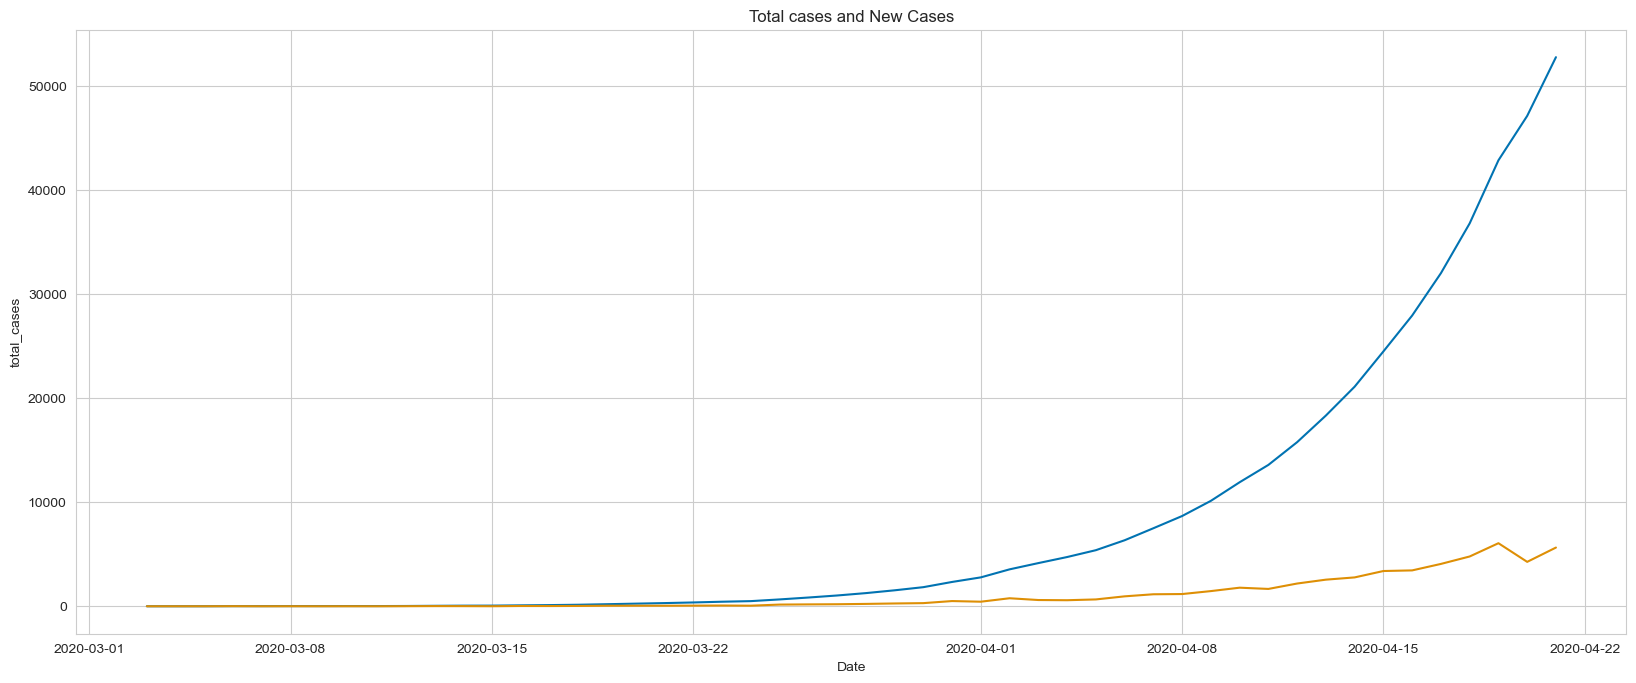

In [207]:
plt.figure(figsize=(20,8))
plt.plot(train['date'], train['total_cases'], label='Total Cases')
plt.plot(train['date'], train['new_cases'], label='New Cases')
plt.title('Total cases and New Cases')
plt.xlabel('Date')
plt.ylabel(target)
plt.show()

In [208]:
regr = linear_model.LinearRegression()
X = train['current_date'].values.reshape(-1, 1)
ln_Y = np.log(train[target]).values.reshape(-1, 1)
regr.fit(X,ln_Y)
train['predicted'] = train['current_date'] * float(regr.coef_) + float(regr.intercept_)

### 2.2 Aposterior Distribution

In [209]:
sigma_noise = np.std(train['predicted'] - np.log(train[target]))

In [210]:
def bayesian_update(mu, sigma, x, y, sigma_noise=sigma_noise):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [211]:
cur_mu, cur_sigma = np.array([0, 0]), 10 * np.array([[1, 0], [0, 1]])

for i in range(50):
    px, py = i + 1, np.log(np.array(train[target][i]))
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py)

In [212]:
print('Aposterior Distribution: ', cur_mu)

Aposterior Distribution:  [1.62082407 0.19833904]


### 2.3 Sample exp: Predicitions on 1st May, 1st June, 1st September

In [213]:
def myplot_sample_lines(mu, sigma, xs=np.arange(0, 60), n=200, points=None):
    # Sample and draw lines
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

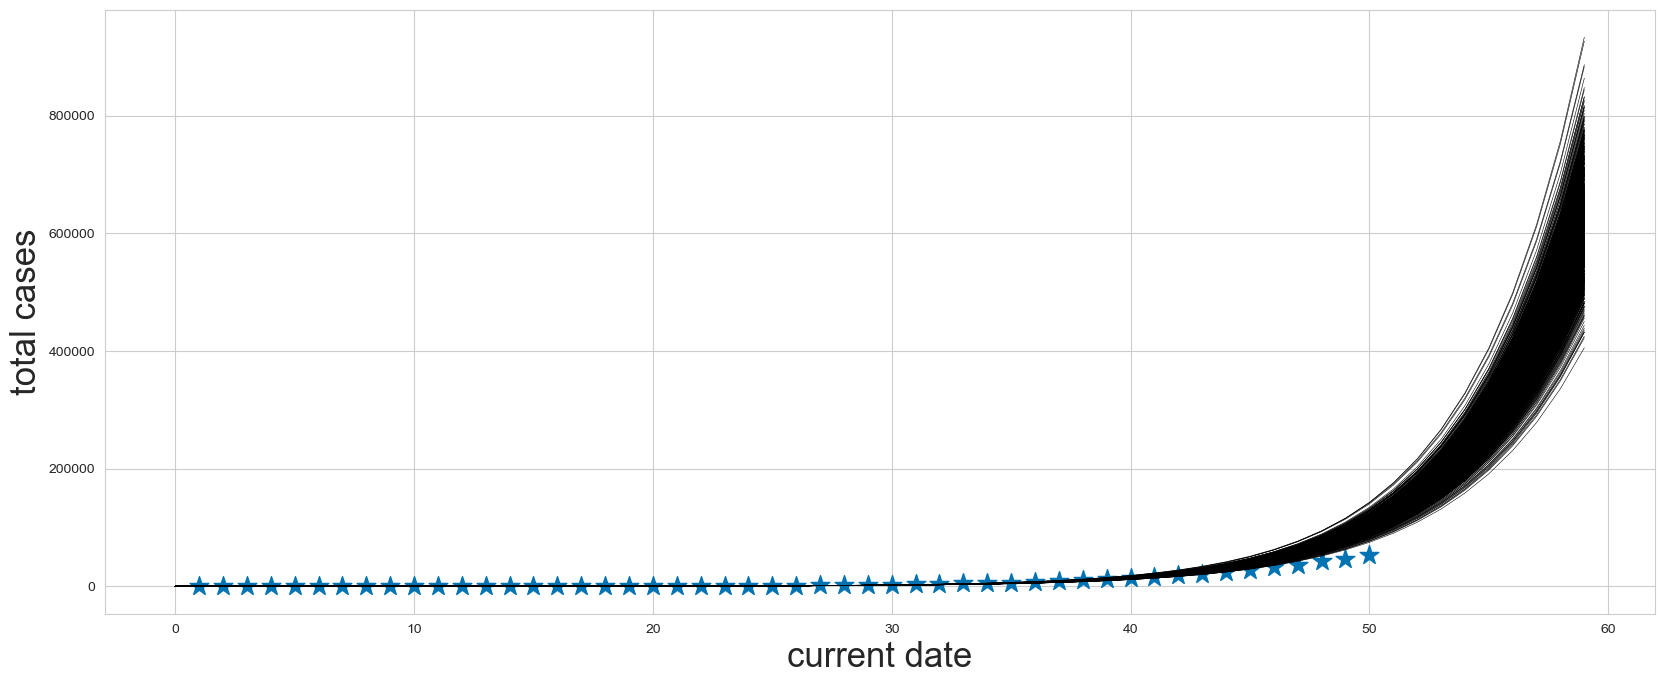

In [214]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
plt.xlabel("current date", fontsize=25)
plt.ylabel("total cases", fontsize=25)
myplot_sample_lines(cur_mu, cur_sigma, n=1000, points=[train['current_date'].values, train['total_cases'].values])

In [215]:
# Draw result
def plot_predictions(xs, mu, x, train_points, test_points):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    plt.xlabel('current_date', fontsize=15)
    plt.ylabel(target, fontsize=15)
    ax.set_xlim((xs[0], xs[-1]))
    ax.plot(xs, np.exp(mu[1]*xs + mu[0]), color="red", label="MAP Hypothesis")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- Dispersion of predictions")
    ax.scatter(train_points[0], train_points[1], marker='*', color="blue", s=100, label="Train")
    ax.scatter(test_points[0], test_points[1], marker='*', color="black", s=100, label="Test")
    ax.legend(fontsize=legend_fontsize)

In [216]:
# Sample lines and give statistics on predictions
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.exp(w[0] + w[1]*xs)
    return res

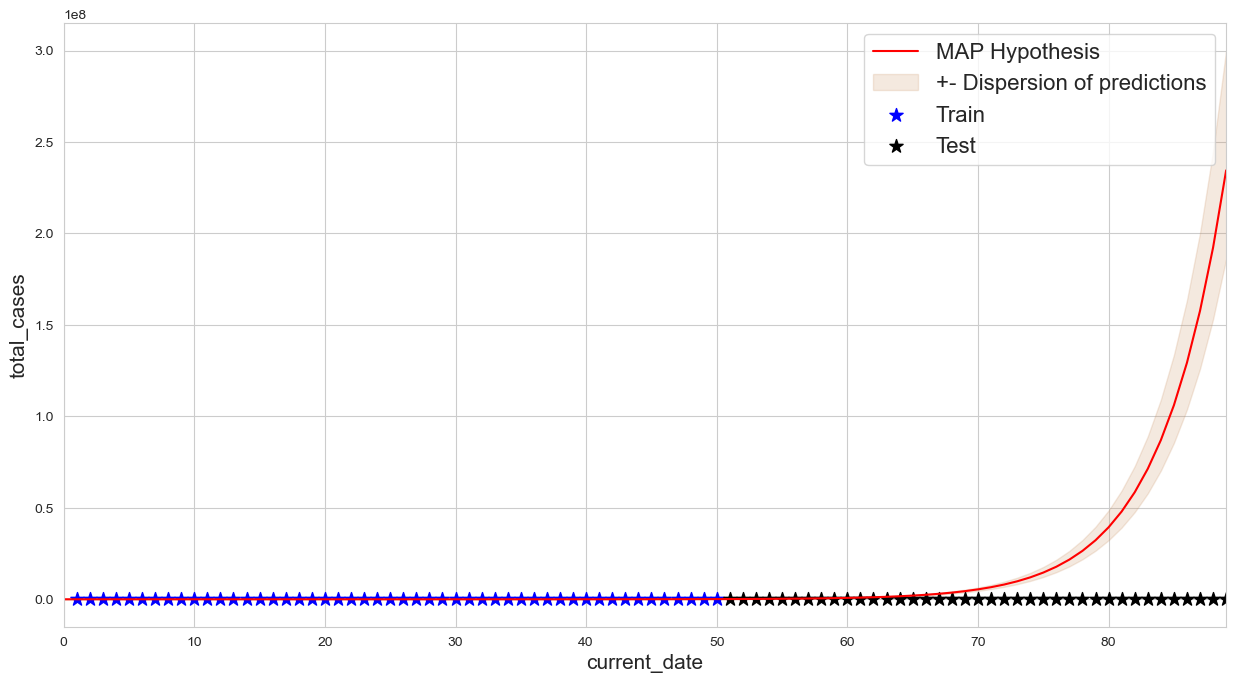

In [217]:
xs = np.arange(0, 90)
x = sample_statistics(cur_mu, cur_sigma, xs, n=200)
plot_predictions(xs, cur_mu, x, [train['current_date'].values, train[target].values], [test['current_date'].values, test[target].values])

In [218]:
def myplot_sample_lines(mu, sigma, xs=np.arange(0, 60), n=200, points=None):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        y = np.exp(w[0] + w[1]*xs)
        plt.plot(xs, y, 'k-', lw=.4, alpha=0.3)
        res[i,:] = y
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
    return res[:,-1]

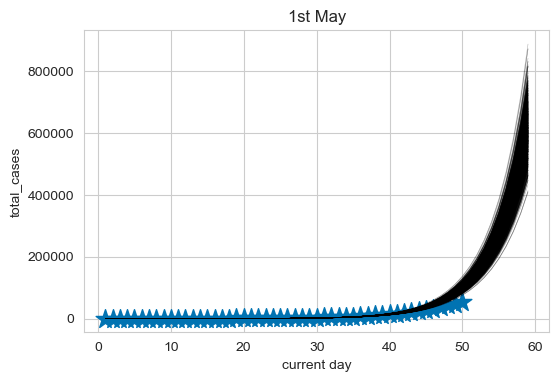

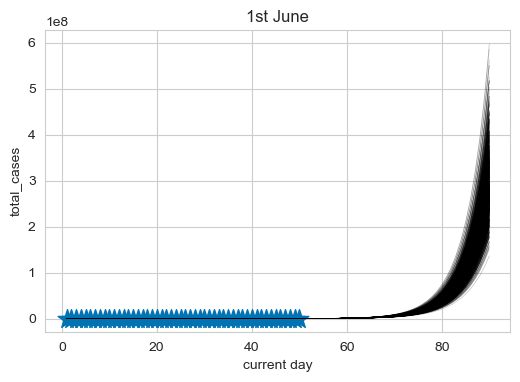

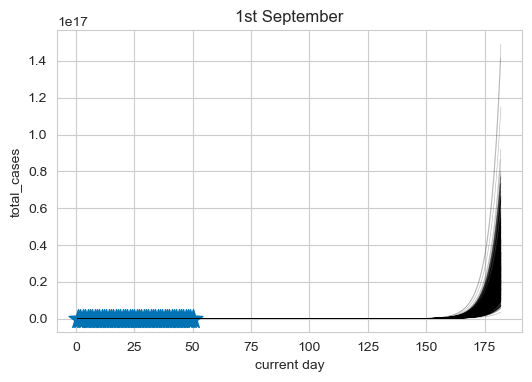

In [219]:
may = myplot_sample_lines(cur_mu, cur_sigma, xs=np.arange(1, (date(2020,5,1) - date(2020,3,3)).days + 1), n=1000, points=[train['current_date'].values, train[target].values])
plt.title("1st May")
plt.xlabel("current day")
plt.ylabel(target)
plt.show()
june = myplot_sample_lines(cur_mu, cur_sigma, xs=np.arange(1, (date(2020,6,1) - date(2020,3,3)).days + 1), n=1000, points=[train['current_date'].values, train[target].values])
plt.title("1st June")
plt.xlabel("current day")
plt.ylabel(target)
plt.show()
september = myplot_sample_lines(cur_mu, cur_sigma, xs=np.arange(1, (date(2020,9,1) - date(2020,3,3)).days + 1), n=1000, points=[train['current_date'].values, train[target].values])
plt.title("1st September")
plt.xlabel("current day")
plt.ylabel(target)
plt.show()

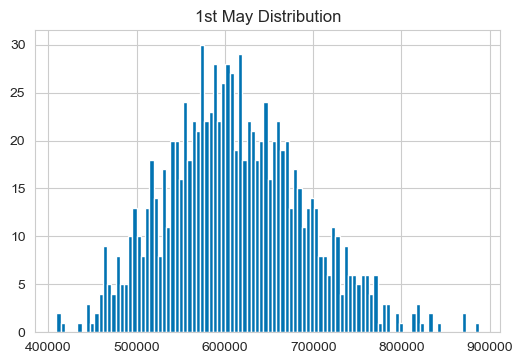

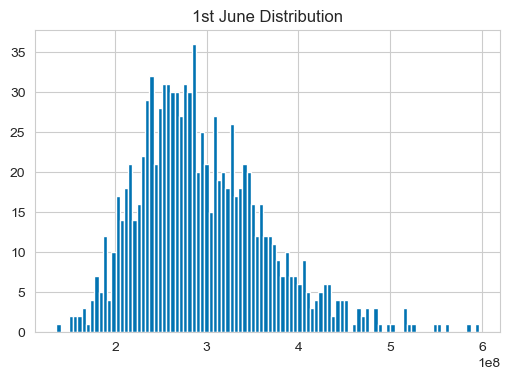

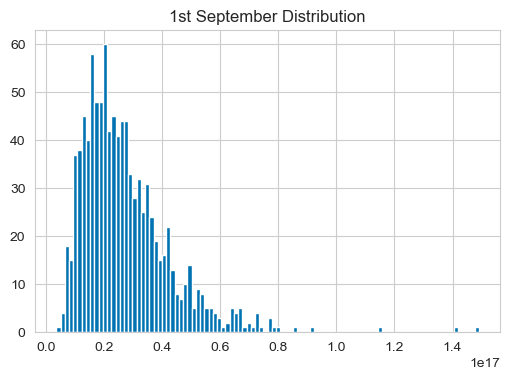

In [220]:
plt.hist(may, bins=100)
plt.title('1st May Distribution')
plt.show()
plt.hist(june, bins=100)
plt.title('1st June Distribution')
plt.show()
plt.hist(september, bins=100)
plt.title('1st September Distribution')
plt.show()

In [221]:
print(f" Average number of total cases on the 1st of May is {may.mean()}")
print(f" Average number of total cases on the 1st of June is {june.mean()}")
print(f" Average number of total cases on the 1st of September is {september.mean()}")

 Average number of total cases on the 1st of May is 612000.6953900254
 Average number of total cases on the 1st of June is 295154594.2994164
 Average number of total cases on the 1st of September is 2.721359842990647e+16


# 3. Linear Regression: second step polynom 

### 3.1 Approach for training

$ \mbox{ 1. The derivative from distibution function is density distribution function } $ \
$ \mbox{ 2. Target total cases is cumulative function from target new cases } $ \
$ \mbox{ 3. Take logarithm from density function,  this will give us polynom of second step: } ax^2 + bx + c $ \
$ \mbox{ 4. So in that case we can train our model with sigmoid where target would be cumulative function of new cases  } \ $

### 3.2 Aposterior Distribution

In [222]:
target = 'new_cases'

In [223]:
regr = linear_model.LinearRegression()
X = train['current_date']
X = np.array(list(zip(X, X**2)))
ln_Y = np.log(train[target]).values.reshape(-1, 1)
regr.fit(X,ln_Y)

LinearRegression()

In [224]:
train['predicted'] = train['current_date'] * float(regr.coef_[:,0]) + (train['current_date'] ** 2) * float(regr.coef_[:,1]) + float(regr.intercept_)
train['cumulative_predicted'] = np.cumsum(train['predicted'])

In [225]:
sigma_noise = np.std(train['predicted'] - np.log(train[target]))

In [226]:
def bayesian_update(mu, sigma, x, y, sigma_noise=sigma_noise):
    x_matrix = np.array([[1, *x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [227]:
cur_mu, cur_sigma = np.array([0, 0, 0]), 10 * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

for i in range(50):
    px, py = X[i], np.log(np.array(train[target][i]))
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py)

In [228]:
print('Aposterior Distribution: ', cur_mu)

Aposterior Distribution:  [-0.67080648  0.2790236  -0.0018255 ]


### 3.3 Sample exp: Predicitions on pessimistic and optimistic scenario

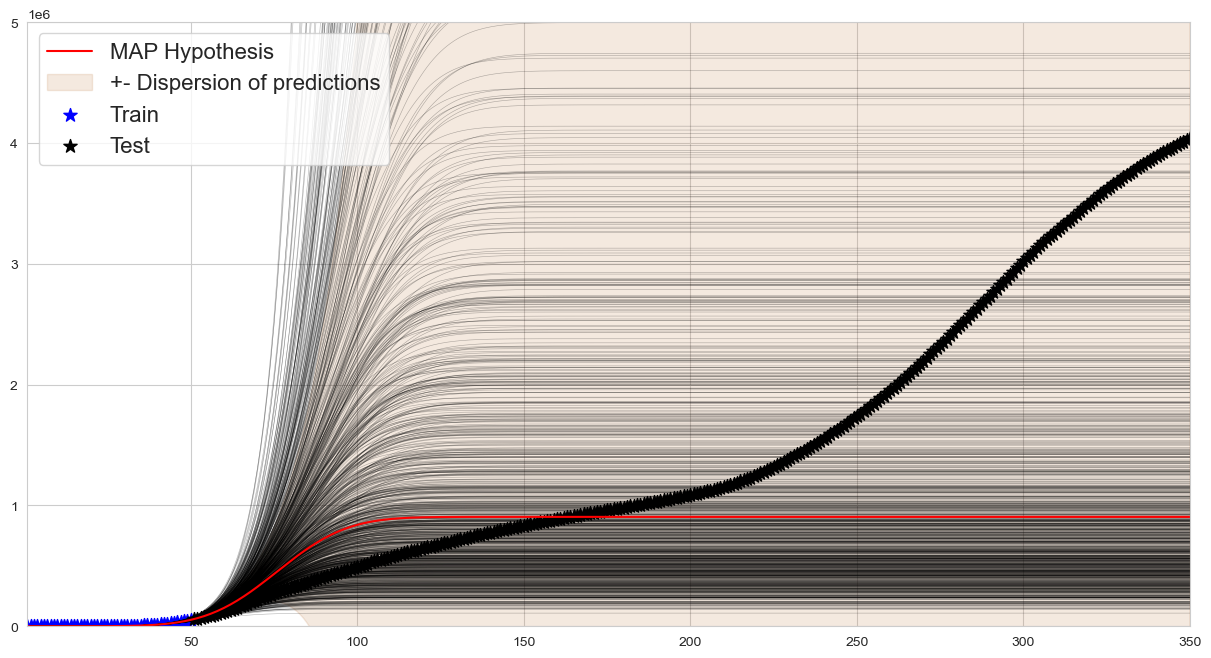

In [229]:
def plot_predictions(xs, mu, sigma, n, train_points, test_points):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((0, 5e6))
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        y = np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))
        ax.plot(xs, y, 'k-', lw=.4, alpha=0.3)
        res[i,:] = y
    ax.plot(xs, np.cumsum(np.exp(mu[2]*(xs**2) + mu[1]*xs + mu[0])), color="red", label="MAP Hypothesis")
    ax.fill_between(xs, np.mean(res, axis=0) - np.std(res, axis=0), np.mean(res, axis=0) + np.std(res, axis=0), color=palette[5], alpha=.2, label="+- Dispersion of predictions")
    ax.scatter(train_points[0], train_points[1], marker='*', color="blue", s=100, label="Train")
    ax.scatter(test_points[0], test_points[1], marker='*', color="black", s=100, label="Test")
    ax.legend(fontsize=legend_fontsize)
    return res[:,-1]

xs = np.arange(1, 351)
dist = plot_predictions(xs, cur_mu, cur_sigma, n=1000, train_points=[np.arange(1, 51), train['total_cases'].values], test_points=[np.arange(51, 351), test['total_cases'].values[:350 - 50]])

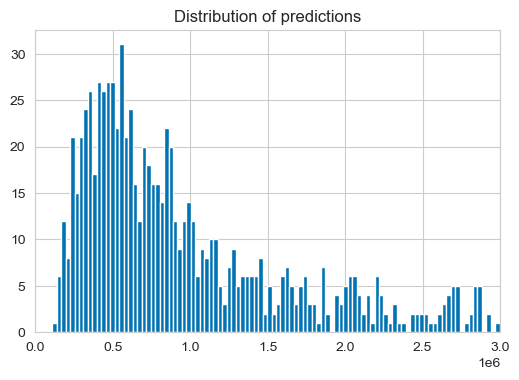

In [230]:
plt.title("Distribution of predictions")
plt.hist(dist[dist < 3e6], bins=100)
plt.xlim((0, 3e6))
plt.show()

In [231]:
print(f"Forecast for pessimistic scenario: {np.percentile(dist, 90)}")
print(f"Forecast for optimistic scenario: {np.percentile(dist, 10)}")

Forecast for pessimistic scenario: 5911732.518270748
Forecast for optimistic scenario: 330357.5403385352
